# Feedforward Neural Networks

With all of the prior material established, I can now turn to the goal of this jupyter book: writing a general feedforward neural network (FNN) function. This function won't be particularly optimised - indeed, it's fairly slow in practice. It does however work.

Since neural networks by their nature are fairly modular, I'll be taking a modular approach to programming this function. I'll start by writing the code for various activation functions, cost functions, their derivatives, weight initialisation functions, and functions to mananage which ones to use given an input string.

From there, I'll write an FNN function that uses all of these internally.

In [1]:
import numpy as np
import copy
from typing import Callable
import matplotlib.pyplot as plt

## Activation Functions

First, I'll implement the activation functions and their derivatives.

Note that we don't really need the softmax derivative as the derivative of the cost with respect to the output nodes' weighted inputs is a known quantity. Because of this, there is a placeholder function that returns None (this is a little inefficient - but avoids me having to rewrite the whole network!):

In [2]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    Element-wise sigmoid function

    Args:
        x: array of values

    Returns: array of transformed values of the same shape as x
    """
    return 1.0 / (1.0 + np.exp(-x))

def deriv_sigmoid(x: np.ndarray) -> np.ndarray:
    """
    Element-wise sigmoid derivative function

    Args:
        x: array of values

    Returns: array of transformed values of the same shape as x
    """
    return sigmoid(x)*(1-sigmoid(x))

In [3]:
def softmax(x: np.ndarray) -> np.ndarray:
    """
    Element-wise softmax function

    Args:
        x: array of values

    Returns: array of transformed values of the same shape as x
    """
    shiftx = x - np.max(x) #creates numerical stability w/out changing result
    expx = np.exp(shiftx)
    return expx / np.sum(expx, axis=0)

def deriv_softmax(x: np.ndarray) -> None:
    """
    Placeholder function for softmax derivative. Not necessary because of
    the formula for dCost/dZ for the output layer
    """
    return None
    

In [4]:
def tanh(x: np.ndarray) -> np.ndarray:
    """
    Element-wise tanh function

    Args:
        x: array of values

    Returns: array of transformed values of the same shape as x
    """
    return (np.exp(x) - np.exp(-x))/(np.exp(x)+np.exp(-x))

def deriv_tanh(x: np.ndarray) -> np.ndarray:
    """
    Element-wise tanh derivative function

    Args:
        x: array of values

    Returns: array of transformed values of the same shape as x
    """
    return 1 - np.power(tanh(x),2)

In [5]:
def relu(x: np.ndarray) -> np.ndarray:
    """
    Element-wise ReLU function

    Args:
        x: array of values

    Returns: array of transformed values of the same shape as x
    """
    return x * (x>=0)

def deriv_relu(x: np.ndarray) -> np.ndarray:
    """
    Element-wise ReLU derivative function

    Args:
        x: array of values

    Returns: array of transformed values of the same shape as x
    """
    return (x>=0).astype("int")

In [6]:
def linear(x: np.ndarray) -> np.ndarray:
    """
    Element-wise linear function

    Args:
        x: array of values

    Returns: array of transformed values of the same shape as x
    """
    return x

def deriv_linear(x: np.ndarray) -> np.ndarray:
    """
    Element-wise linear derivative function

    Args:
        x: array of values

    Returns: array of transformed values of the same shape as x
    """
    return np.ones(x.shape)

## Cost Functions

Next, the cost functions and their derivatives. We don't actually need to compute the cost to estimate a neural network, but I think it's useful to demonstrate how it can be done.

As with softmax, we also don't need the derivative of cross-entropy as the derivative of the cost with respect to the output nodes' weighted inputs is a known quantity.

In [7]:
def mse(yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    MSE cost function

    Args:
        yhat: Array of predicted values
        y: Array of true values

    Returns: An array of costs
    """
    return np.power(yhat-y,2)

def deriv_mse(yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    MSE cost derivative function

    Args:
        yhat: Array of predicted values
        y: Array of true values

    Returns: An array of cost derviatives
    """
    return 2*(yhat-y)

In [8]:
def binary_cross_entropy(yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Binary cross entropy cost function

    Args:
        yhat: Array of predicted values
        y: Array of true values

    Returns: An array of costs
    """
    return -y * np.log(yhat) - (1-y)*np.log(1-yhat)

def deriv_binary_cross_entropy(yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Binary cross entropy cost derivatives function

    Args:
        yhat: Array of predicted values
        y: Array of true values

    Returns: An array of cost derivatives
    """
    return -(y/yhat) + (1-y)/(1-yhat)

In [9]:
def cross_entropy(yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Cross entropy cost function

    Args:
        yhat: Array of predicted values
        y: Array of true values

    Returns: An array of costs
    """
    return np.sum(-y*np.log(yhat),axis=0)

def cross_entropy_deriv(yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Placeholder cross entropy cost derivatives function. Not required
    in practice as softmax dZ term is known

    Args:
        yhat: Array of predicted values
        y: Array of true values

    Returns: An array of cost derivatives
    """
    return None

## Managing Activation and Cost Function Choice

To aid in managing all of these, I also wrote some functions that return the relevant functions based on an input string. This means the final FNN function will take a string as input to describe the hidden and output activations. I could also have passed the functions directly, but this helped render the code a little clearer.

In [10]:
def get_activation(name: str) -> Callable:
    """
    A function to manage which activation function and
    derivative to use given input string

    Args:
        name: the name of the activation function

    Returns: The activation function and its derivative
    """
    if name == "sigmoid":
        return sigmoid, deriv_sigmoid
    if name == "softmax":
        return softmax, deriv_softmax
    if name == "tanh":
        return tanh, deriv_tanh
    if name == "relu":
        return relu, deriv_relu
    if name == "linear":
        return linear, deriv_linear

def get_cost(name: str) -> Callable:
    """
    A function to manage which cost function and
    derivative to use given input string

    Args:
        name: the name of the cost function

    Returns: The cost function and its derivative
    """
    if name == "mse":
        return mse, deriv_mse
    if name == "bce":
        return binary_cross_entropy, deriv_binary_cross_entropy
    if name == "ce":
        return cross_entropy, cross_entropy_deriv

## Weight Initialisation

An important step in setting up a neural network is initialising the weights. The network won't be successfully estimated if we initialise the weights at 0, and it's possible to initialise weights in such a manner that exploding or shrinking gradients are encouraged from the start. To avoid that outcome, I've therefore implemented some established weight initialisation algorithms here:

In [11]:
def xavier_init(shape: tuple[int]) -> np.ndarray:
    """
    Xavier initialisation of weights

    Args:
        shape: tuple giving the shape of the weights

    Returns: np.ndarray of initialised weights
    """
    num_input = shape[1]
    num_output = shape[0]
    W = np.random.randn(num_output, num_input) / num_input
    return W

def he_init(shape: tuple[int]):
    """
    He initialisation of weights

    Args:
        shape: tuple giving the shape of the weights

    Returns: np.ndarray of initialised weights
    """
    num_input = shape[1]
    num_output = shape[0]
    W = np.random.randn(num_output, num_input) * np.sqrt(2/num_input)
    return W

def linear_init(shape: tuple[int]) -> np.ndarray:
    """
    Simple initialisation of weights

    Args:
        shape: tuple giving the shape of the weights

    Returns: np.ndarray of initialised weights
    """
    num_input = shape[1]
    num_output = shape[0]
    W = np.random.randn(num_output, num_input)/num_input
    return W

def get_init(name: str) -> Callable:
    """
    A function to manage which weights initalisation
    to use

    Args:
        name: the name of the activation function

    Returns: An initialisation function
    """
    if name == "sigmoid" or name == "softmax" or name == "tanh":
        return xavier_init
    if name == "relu":
        return he_init
    if name == "linear":
        return linear_init
    

## Forward Propagation

Here I implement the forward propagation algorithm. This takes the input features matrix X, the weights, the biases, and the activiation function, and propagates the data forward through the network to produce a prediction.

Note that since A_list stores X as its first entry for ease of computation for both the forward and backward passes, its indices correspond to the hidden layers (i.e. A\[i\] would correspond to the ith hidden layer). So, on the fisrt part of the loop (i=0), A\[i\] would be A\[0\] and thus correspond to X. While Z\[i\] = Z\[0\] would be for i+1 - i.e. the first layer's weighted input.

In [12]:
def forward_pass(X: np.ndarray,
                 W_list: list[np.ndarray],
                 B_list: list[np.ndarray],
                 activation_hidden: Callable,
                 activation_output: Callable,
                 num_pass: int):
    """
    A function that performs forward-propagation through a network

    Args:
        X: matrix of input features
        weight_list: A list with num_features_out by num_features_in weight
                     matrices, where num_features_out is the number of outputs
                     to the layer and num_features_in is the number of inputs to
                     the layer
        bias_list: A list with num_features_out by 1 bias matrices, where
                   num_features_out is the number of outputs to the layer
        activation_hidden: Activation function for hidden layers
        activation_output: Activation function for the output layer
        num_pass: Number of forward passes

    Returns: Z_list, a list of layer weighted inputs, and A_list, a list of
             activated weighted inputs. Both contain X as their first entry
    """
    Z_list = []
    A_list = [X] #for use in backprop
    for i in range(num_pass):
        Z_list.append(np.dot(W_list[i],A_list[i]) + B_list[i])
        if i < (num_pass-1):
            A_list.append(activation_hidden(Z_list[i]))
        elif i == (num_pass-1):
            A_list.append(activation_output(Z_list[i]))

    return Z_list, A_list

## Back Propagation

And finally, here I implement the backpropagation algorthim. Note the slightly different implementations for dCost/dZ for the output layer depending on if softmax is used or not.

As with forward propagation, the A_list contains X as an additional element - and so its indices behave slightly different to the other lists' indices.

In [13]:
def back_pass(Y: np.ndarray,
              W_list: list[np.ndarray],
              Z_list: list[np.ndarray],
              A_list: list[np.ndarray],
              cost_deriv: Callable,
              activation_hidden_deriv: Callable,
              activation_output_deriv: Callable,
              num_pass: int,
              num_obs: int,
              softmax: bool):
    """
    A function to perform backpropagation through the network

    Args:
        Y: array of output variables
        W_list: list of layer weights
        Z_list: list of layer weighted inputs
        A_list: list of layer activations
        cost_deriv: Cost derivative function
        activation_hidden_deriv: Hidden layer activation func derivative
        activation_output_deriv: Output layer activation func derivative
        num_pass: Number of forward/backward passes
        num_obs: Number of training examples/observations

    Returns: dW_list, a list of weight derivatives, and dB_list, a list of
             bias derivatives
    """
    if softmax:
        dZ = A_list[num_pass] - Y
    if not softmax: 
        dZ = np.multiply(cost_deriv(A_list[num_pass], Y), activation_output_deriv(Z_list[num_pass-1]))
    dW_list = [np.dot(dZ, A_list[num_pass-1].T)/num_obs]
    dB_list = [np.sum(dZ, axis=1, keepdims=True)/num_obs]
    for i in range(num_pass-1, 0, -1):
        dZ = np.multiply(np.dot(W_list[i].T, dZ), activation_hidden_deriv(Z_list[i-1]))
        dW_list = [np.dot(dZ, A_list[i-1].T)/num_obs] + dW_list
        dB_list = [np.sum(dZ, axis=1, keepdims=True)/num_obs] + dB_list
    return dW_list, dB_list

## A Feedforward Neural Network Function

With all of the above functions impelemented, it's time to put them all together. This function does a few things:

- Puts data in desired format (num_features by num_observations, instead of vice versa)
- Uses the functions above to prepare the activation functions, cost function, and their derivatives
- Runs a training loop. During a single cycle of the loop, it will:
  - Forward-propagate the data to calculate the weighted inputs and activations
  - Back-propagate to compute the gradients of the weights and the biases
  - Update the weights according to gradient descent 
- This loop has two break conditions:
  - The max number of iterations is reached
  - The change in weights becomes sufficiently small

Finally, the function produces three outputs, two of which I'll use in this jupyter book:

- The network's predicted values for the input data
- The overall cost of the network
- A function built from the forward propagation function above that will generate predictions for new data

There's no reason I coudln't have included other outputs such as the estimated weights, the final difference, or the final number of iterations. I don't use the cost here, but since it's not actually used in estimating the network I didn't want it to be entirely superfluous to requirements.


In [14]:

def fnn(X,
        Y,
        hidden,
        learn_rate=0.03,
        hidden_activation="relu",
        output_activation="linear",
        loss="mse",
        tol=0.0001,
        max_iter=10000):
    """
    A feedforward neural network function that allows an arbitary number of 
    hidden layers and 

    Args:
        X: A num_obs by num_features input matrix
        Y: A num_obs by num_outputs matrix
        hidden: A list of length num_hidden_layers where the nth entry describes
                the number of nodes for the nth hidden layer.
        learn_rate: Learning rate of the network.
        hidden_activation: String denoting activation function for hidden layers.
        output_activation: String denoting activation function for output layer.
        loss: String denoting the loss function
        tol: Minimum difference for break criteria in the training loop
        max_iter: Maximum number of training iterations.
    """
    
    # Data will be aligned in a different format to the network
    X = X.T
    Y = Y.T
    
    # Initialise network: core numbers
    shape_X = X.shape
    num_obs = shape_X[1]
    indices = list(range(num_obs))
    num_features = shape_X[0]
    shape_Y = Y.shape
    num_output = shape_Y[0]
    num_hidden = len(hidden)
    num_pass = num_hidden + 1 #passes between layers
    
    # Initialise network: weights W:
    hidden_init, output_init = get_init(hidden_activation), get_init(output_activation)
    W_list =  [hidden_init((hidden[0], num_features))]
    for i in range(1, num_hidden):
        W_list.append(hidden_init((hidden[i], hidden[i-1])))
    W_list.append(output_init((num_output, hidden[num_hidden-1])))
    
    # Initialise network: biases B
    B_list = []
    for i in range(num_hidden):
        B_list.append(np.zeros((hidden[i],1)))
    B_list.append(np.zeros((num_output, 1)))
    
    # Initalise network: activation + cost funcs and their derivatives
    activation_hidden, activation_hidden_deriv = get_activation(hidden_activation)
    activation_output, activation_output_deriv = get_activation(output_activation)
    cost_func, cost_deriv = get_cost(loss)
    softmax_bool = output_activation == "softmax"
    
    # Training loop
    iter = 0
    diff = np.inf
    while (iter < max_iter and diff > tol):
        # Compute forward pass
        Z_list, A_list = forward_pass(X=X,
                                      W_list=copy.deepcopy(W_list),
                                      B_list=copy.deepcopy(B_list),
                                      activation_hidden=activation_hidden,
                                      activation_output=activation_output,
                                      num_pass=num_pass)
        
        # Backpropagate to find gradients
        dW_list, dB_list = back_pass(cost_deriv=cost_deriv,
                                     Y=copy.deepcopy(Y),
                                     activation_output_deriv=activation_output_deriv,
                                     activation_hidden_deriv=activation_hidden_deriv,
                                     W_list=copy.deepcopy(W_list),
                                     A_list=copy.deepcopy(A_list),
                                     Z_list=copy.deepcopy(Z_list),
                                     num_pass=num_pass,
                                     num_obs=num_obs,
                                     softmax=softmax_bool)
        
        # Update params (w_new = w_old - learn_rate * gradient(w_old))
        W_old = copy.deepcopy(W_list)
        B_old = copy.deepcopy(B_list)
        new_diff = 0
        for i in range(num_pass):
            W_list[i] = W_list[i] - (learn_rate * dW_list[i])
            B_list[i] = B_list[i] - (learn_rate * dB_list[i])
            new_diff += np.sum(np.abs(W_list[i] - W_old[i])) + np.sum(np.abs(B_list[i] - B_old[i]))
        diff = new_diff

        # Increment iterations
        iter += 1
    
    # Predicted values of the network
    prediction = A_list[num_pass].T
    
    # Cost of the network
    cost = np.sum(cost_func(A_list[num_pass], Y)) / num_obs
    
    # Prediction function for new data
    def fnn_pred_func(newdata):
        new_X = newdata.T
        _, A_list = forward_pass(X=new_X,
                                 W_list=W_list,
                                 B_list=B_list,
                                 activation_hidden=activation_hidden,
                                 activation_output=activation_output,
                                 num_pass=num_pass)
        return A_list[num_pass].T
    
    # Return Yhat
    return prediction, cost, fnn_pred_func
    
    
    

## Example 1: Learning XOR

With the network function implemented, it's time to put it to the test. For the first test, I'll run it on XOR. If you're unfamiliar with XOR, it's a logical operation read as 'exclusive OR'. It takes two binary inputs. If one *but not the other* is true, then it returns true. If both inputs are false, or if both inputs are true, it returns false.

In [15]:
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])
Y = np.array([[0],[1],[1],[0]])

print(X)
print(Y)

[[0 0]
 [0 1]
 [1 0]
 [1 1]]
[[0]
 [1]
 [1]
 [0]]


The difficulty of XOR is that it's plainly non-linear to the inputs. Without using interactions, it would be impossible to model in any kind of linear model. The power of neural networks however is that they can approximate any function, including non-linear functions.

In this case, all we need is a single hidden layer with 2 neurons. With this, we should have enough to estimate a reasonably accurate network.

Since none of the inputs are negative, ReLU would be a poor choice of activation function, as with negative weights a neuron would become 'dead' (unless a different initialisation which prevented negative weights was used). I therefore chose a sigmoid activation for the hidden layer.

Similarly, since the output layer is binary, I used a sigmoid output activation and binary cross-entropy loss function.

Since all the possible feature combinations of XOR are known, I examined only the predicted output for the input data in this case.

In [16]:
np.random.seed(42)
pred, _, _ = fnn(X=X,
                 Y=Y,
                 hidden=[2],
                 learn_rate=0.9,
                 hidden_activation="sigmoid",
                 output_activation="sigmoid",
                 loss="bce")
print(np.round(pred,2))

[[0.]
 [1.]
 [1.]
 [0.]]


As you can see, the network successfully estimates the correct values for XOR. While this demonstrates the network's ability to approximate non-linear functions through the use of hidden layers and appropriate activation functions.

## Example 2: Digit Classification

XOR is a however fairly simple example - so let's turn to something more involved. I'm now going to test my FNN function on one of the sklearn toy datasets. In particular, I'm going to test it on the handwritten digits toy dataset.

This is a dataset of 8x8 pixel images of digits ranging from 0 to 9. I'll attempt to classify the images based on the individual pixels. First, I'll download the data split it into training and test data:

In [17]:
# Download data
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
data, target = load_digits(n_class=10, return_X_y=True, as_frame=False)
target = target.reshape((target.shape[0],1))

# Split data
indices = list(range(data.shape[0]))
train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=target)
train_X = data[train_indices,:]
train_Y = target[train_indices,:]
test_X = data[test_indices,:]
test_Y = target[test_indices,:]

# One-hot encode the targets
num_classes = 10
def one_hot(vec):
    oh = np.eye(num_classes)[vec].reshape((vec.shape[0],-1))
    return oh
train_Y_oh = one_hot(train_Y)
test_Y_oh = one_hot(test_Y)


With the data prepared, I'll now train a network on it. Unlike XOR, there is not a limited set of possible feature combinations, so this time the emphasis will be on how well the model predicts new data. I thus focus on the prediction function output.

Since this dataset is more complex (64 features, 10 classes), I used a more complex network setup. In this case, a network with two hidden layers. The first hidden layer contains 20 neurons, the second 10 neurons, for a total of 40 hidden layer neurons.

For similar reasons in the case of XOR, I used a sigmoid activation function for the hiddden layers. This time however, since our output is not one but many classes, I used a softmax output activation and cross-entropy loss function.

In [18]:
np.random.seed(3298)
_, _, pred_func = fnn(X=train_X,
                      Y=train_Y_oh,
                      hidden=[20,10],
                      learn_rate=0.9,
                      hidden_activation="sigmoid",
                      output_activation="softmax",
                      loss="ce",
                      max_iter=10000)

With the network estimated, I'll now get the predictions from the network. Since I don't want to compare against probabilities, I'll use the value the network considers likeliest given the test data:

In [19]:
prediction = pred_func(test_X)
prediction_vec = prediction.argmax(1,keepdims=True)

To visualise this, let's look at the first image in the test dataset:

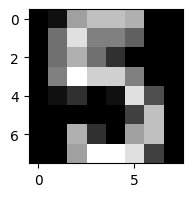

In [20]:
img = test_X[0]
plt.figure(figsize=(2,2))
plt.imshow(img.reshape(8,8), cmap='gray')

And let's compare this to our network's prediction:

In [21]:
print(f"Predicted number: {prediction_vec[0][0]}")

Predicted number: 5


We got the correct value!

Of course, we don't want to look only at a single value. So let's compute the perentage of the labels that were correctly predicted:

In [22]:
np.sum(test_Y == prediction_vec) / len(test_Y)

0.95

95% of predictions are correct! Pretty good going as far as handwritten digit recognition goes.

This concludes the demonstration of the feedforward neural network function. It works for arbitrarily sized data and for arbitarily sized neural networks, although it will probably be fairly slow in practice for larger datasets and networks. The ultimate goal of the juptyer book has therefore been realised.